# Análisis de datos NBA

Este notebook analiza datos de tiro de varios jugadores de la NBA.

Datos descargados usando el [nba_data_loader.py](../nba_data_loader.py) y mapeados con [map_shot_board_zones.py](../map_shot_board_zones.py)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from matplotlib.patches import Patch
from pathlib import Path
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

In [3]:
# Ruta a la carpeta de datos
data_folder = Path("../data")

# Listar todos los archivos *_shots.csv
csv_files = list(data_folder.glob("*_shots.csv"))
num_players = len(csv_files)

#### Dispersión global de tiros

In [4]:
zone_colors = {
    'Center(C)': '#e41a1c',           # rojo
    'Left Side(L)': '#377eb8',        # azul
    'Right Side(R)': '#4daf4a',       # verde
    'Left Side Center(LC)': "#b160bd",# morado
    'Right Side Center(RC)': '#ff7f00',# naranja
    'Back Court(BC)': "#1E1C1C"       # magenta intenso (destaca mucho)
}


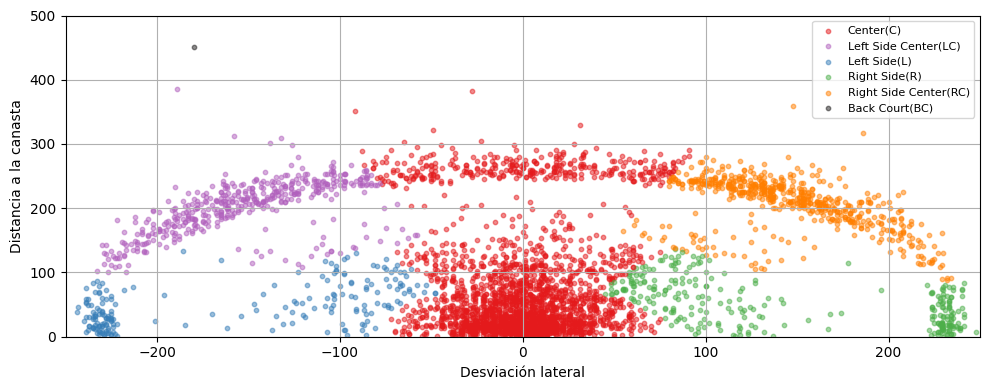

In [ ]:
plt.figure(figsize=(10, 4))

x_min, x_max = -250, 250
y_min, y_max = 0, 500  # elimina outliers por encima de 500

for file in csv_files:
    df = pd.read_csv(file)
    # Elimina outliers y NaNs
    df = df.dropna(subset=["LOC_X", "LOC_Y", "SHOT_ZONE_AREA"])
    df = df[(df["LOC_Y"] <= y_max) & (df["LOC_Y"] >= y_min) & (df["LOC_X"] >= x_min) & (df["LOC_X"] <= x_max)]
    for zone, group in df.groupby("SHOT_ZONE_AREA"):
        color = zone_colors.get(zone, "gray")
        plt.scatter(group["LOC_X"], group["LOC_Y"], alpha=0.5, s=10, color=color, label=zone)

# Quitar duplicados en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=8)

plt.xlabel("Desviación lateral")
plt.ylabel("Distancia a la canasta")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Dispersión individual de tiros por jugador

- De los datos extraidos de la propia NBA API

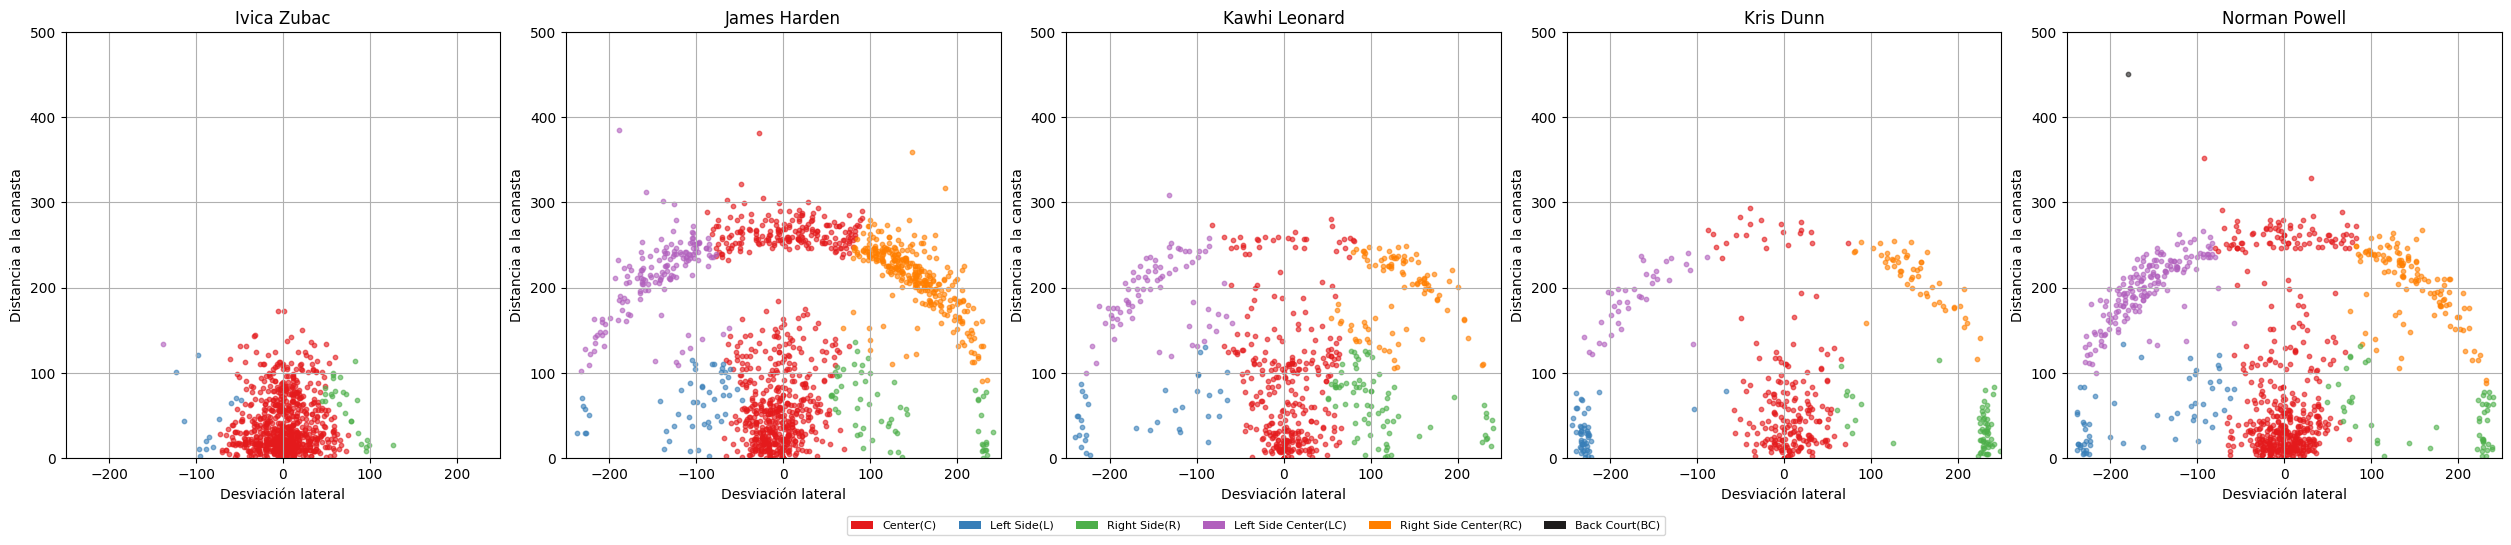

In [ ]:
x_min, x_max = -250, 250
y_min, y_max = 0, 500  # elimina outliers por encima de 500

fig, axs = plt.subplots(1, num_players, figsize=(5 * num_players, 5), constrained_layout=True)

if num_players == 1:
    axs = [axs]

for i, file in enumerate(csv_files):
    player_name = os.path.basename(file).replace("_shots.csv", "").replace("_", " ").title()
    df = pd.read_csv(file).dropna(subset=["LOC_X", "LOC_Y", "SHOT_ZONE_AREA"])
    # Elimina outliers
    df = df[(df["LOC_Y"] <= y_max) & (df["LOC_Y"] >= y_min) & (df["LOC_X"] >= x_min) & (df["LOC_X"] <= x_max)]
    
    ax = axs[i]
    for area, group in df.groupby("SHOT_ZONE_AREA"):
        color = zone_colors.get(area, "gray")
        ax.scatter(group["LOC_X"], group["LOC_Y"], color=color, s=10, alpha=0.6)

    ax.set_title(player_name)
    ax.set_xlabel("Desviación lateral")
    ax.set_ylabel("Distancia a la canasta")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

legend_elements = [Patch(facecolor=color, label=zone) for zone, color in zone_colors.items()]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.07),
    ncol=len(zone_colors),
    fontsize=8
)
plt.show()

- Tras el mapeado

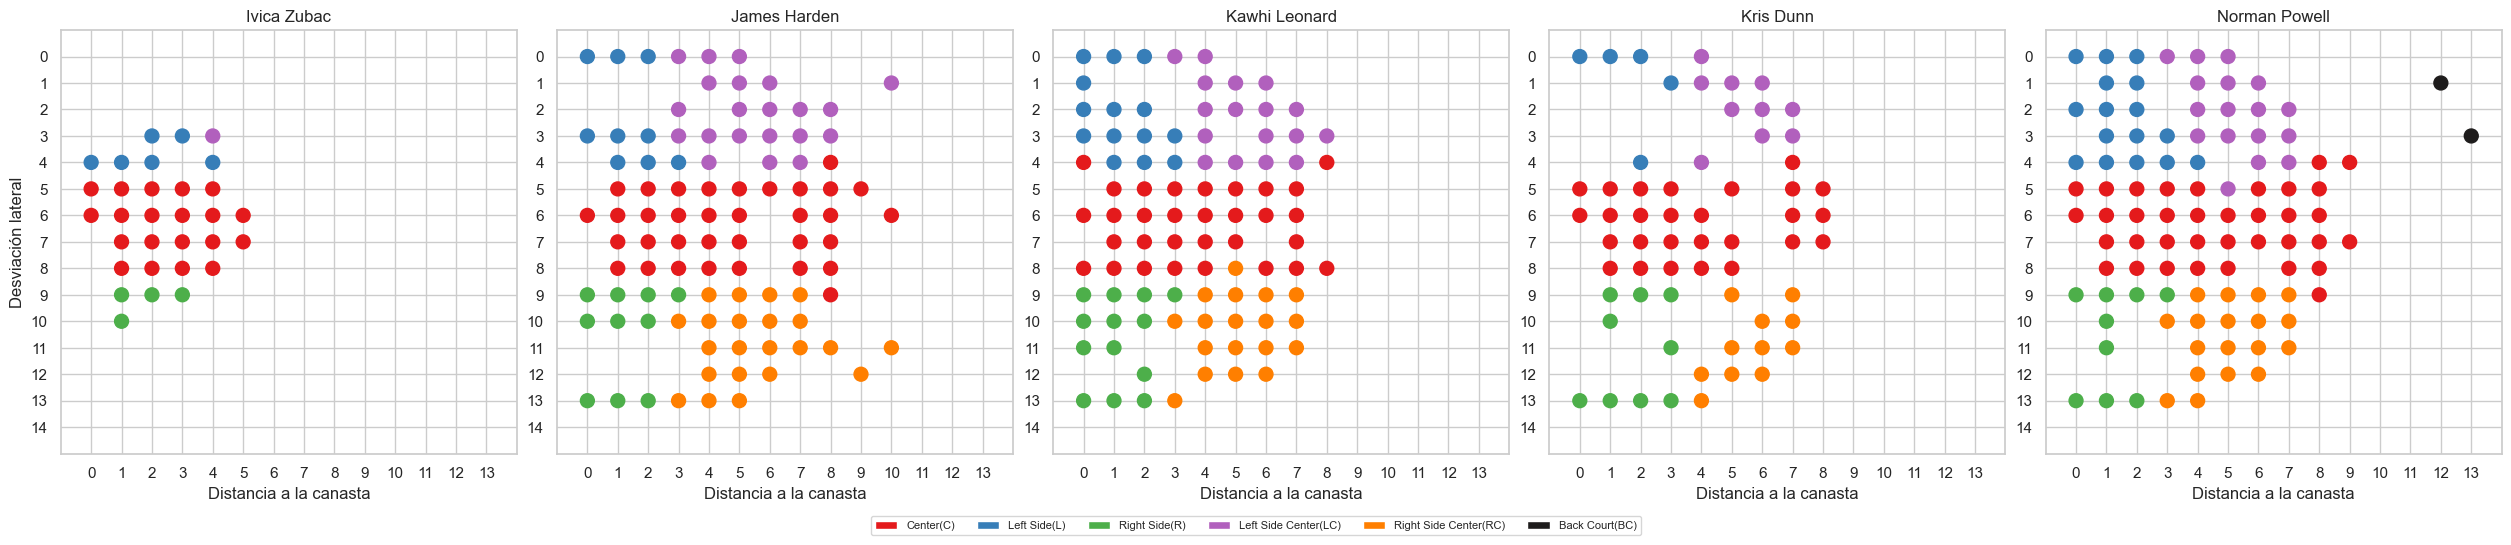

In [ ]:
# Parámetros del tablero
ROWS, COLS = 15, 14

# Cargar los perfiles de tiro desde el JSON
with open("../data/player_shooting_profiles.json", "r") as f:
    shooting_profiles = json.load(f)

# Número de jugadores
num_players = len(shooting_profiles)

fig, axs = plt.subplots(1, num_players, figsize=(5 * num_players, 5), constrained_layout=True)
if num_players == 1:
    axs = [axs]

for i, (player, profile) in enumerate(shooting_profiles.items()):
    x_vals, y_vals, colors = [], [], []
    for cell, data in profile.items():
        row, col = eval(cell)
        zone = data.get("zone", "")
        color = zone_colors.get(zone, "gray")
        x_vals.append(col)  # X = COL (horizontal)
        y_vals.append(row)  # Y = ROW (vertical)
        colors.append(color)

    axs[i].scatter(x_vals, y_vals, color=colors, s=100)
    axs[i].set_title(player.replace("_", " ").title())
    axs[i].set_xlim(-1, COLS)
    axs[i].set_ylim(-1, ROWS)
    axs[i].invert_yaxis()  
    axs[i].set_xticks(range(COLS))
    axs[i].set_yticks(range(ROWS))
    axs[i].set_xlabel("Distancia a la canasta")
    if i == 0:
        axs[i].set_ylabel("Desviación lateral")
    axs[i].grid(True)

legend_elements = [Patch(facecolor=color, label=zone) for zone, color in zone_colors.items()]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.07),
    ncol=len(zone_colors),
    fontsize=8
)
plt.show()


# Evaluación del modelo KNN para rellenar perfiles de tiro

Se evalúa la calidad de las predicciones de KNN usadas para completar celdas vacías en los perfiles de tiro de jugadores de la NBA.

In [ ]:
sns.set(style="whitegrid")
ROWS, COLS = 15, 14

In [57]:
original_path = os.path.join(data_folder, "player_shooting_profiles.json")
filled_path = os.path.join(data_folder, "player_shooting_profiles_knn.json")

with open(original_path, "r") as f:
    original_profiles = json.load(f)

with open(filled_path, "r") as f:
    filled_profiles = json.load(f)

print("Jugadores cargados:", list(original_profiles.keys()))

Jugadores cargados: ['ivica_zubac', 'james_harden', 'kawhi_leonard', 'kris_dunn', 'norman_powell']


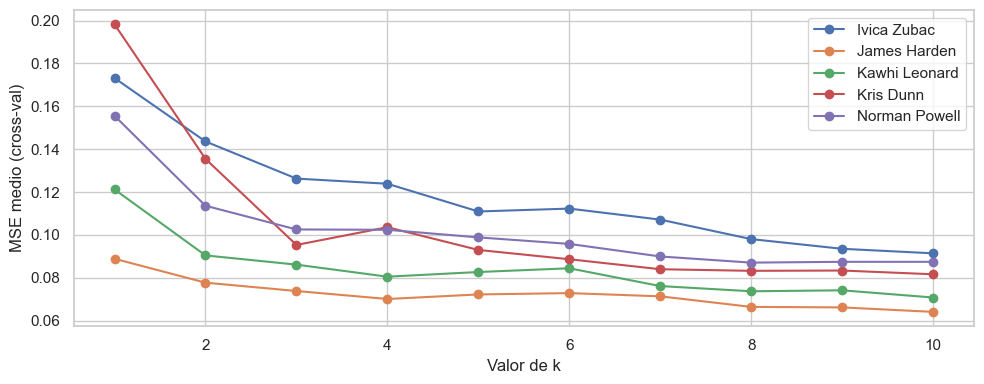

In [ ]:
# Evaluar KNN con validación cruzada (MSE y STD)
def evaluate_knn_cv(profile, k=10):
    X, y = [], []
    for key, val in profile.items():
        r, c = eval(key)
        X.append([r, c])
        y.append(val["prob"])

    if len(X) < k:
        return None, None

    model = KNeighborsRegressor(n_neighbors=k)
    scores = -cross_val_score(model, X, y, cv=KFold(n_splits=3), scoring="neg_mean_squared_error")
    return scores.mean(), scores.std()

# Evaluar para todos los k y guardar MSE y STD
k_values = list(range(1, 11))
mse_by_k = {player: [] for player in original_profiles}
std_by_k = {player: [] for player in original_profiles}

for k in k_values:
    for player, profile in original_profiles.items():
        mean_mse, std_mse = evaluate_knn_cv(profile, k=k)
        if mean_mse is not None:
            mse_by_k[player].append(mean_mse)
            std_by_k[player].append(std_mse)
        else:
            mse_by_k[player].append(np.nan)
            std_by_k[player].append(np.nan)

plt.figure(figsize=(10, 4))
for player, mse_list in mse_by_k.items():
    plt.plot(k_values, mse_list, marker='o', label=player.replace('_', ' ').title())

plt.xlabel("Valor de k")
plt.ylabel("MSE medio (cross-val)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


En general, el mejor k para todos los casos es k = 10:

In [ ]:
print("Desviación estándar del MSE para k=10:")
for player in original_profiles:
    mse_value = mse_by_k[player][9] 
    std_value = std_by_k[player][9]  
    print(f"{player.replace('_', ' ').title()} → mse={mse_value:.4f} | std={std_value:.4f}")

Desviación estándar del MSE para k=10:
Ivica Zubac → mse=0.0914 | std=0.0300
James Harden → mse=0.0641 | std=0.0107
Kawhi Leonard → mse=0.0708 | std=0.0152
Kris Dunn → mse=0.0816 | std=0.0146
Norman Powell → mse=0.0874 | std=0.0183


: 